In [3]:
import keras_nlp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
import cv2

In [89]:
class Patches(keras.layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = tf.shape(images)
        print(input_shape)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        # print(images, [1, self.patch_size, self.patch_size,1], [1, self.patch_size, self.patch_size, 1])
        patches = tf.image.extract_patches(images, 
                                           sizes=[1, self.patch_size, self.patch_size,1],
                                           strides=[1, self.patch_size, self.patch_size, 1],
                                           rates=[1, 1, 1, 1],
                                           padding='VALID')
        patches = tf.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

tf.Tensor([  1 200 200   3], shape=(4,), dtype=int32)
Image size: 200 X 200
Patch size: 16 X 16
Patches per image: 144
Elements per patch: 768


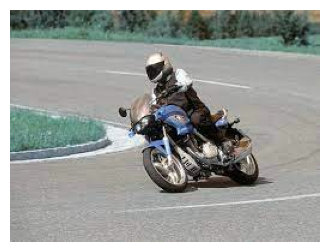

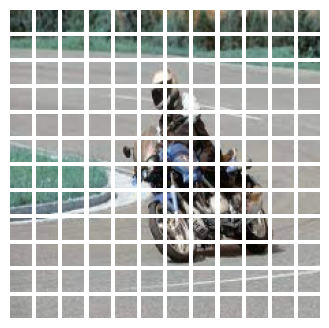

In [90]:
image_size = 200
patch_size = 16

plt.figure(figsize=(4, 4))
image = cv2.imread("../test.jpeg")
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow((patch_img.numpy()).astype("uint8"))
    plt.axis("off")

In [91]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.expand_dims(
            tf.range(start=0, limit=self.num_patches, delta=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [92]:
PatchEncoder(patches.shape[1], 20)(patches).shape

TensorShape([1, 144, 20])

In [121]:
input_shape = (64, 512)
patch_size = 16
num_patches = input_shape[0]//patch_size * input_shape[1]//patch_size
projection_dim = 256
num_classes = 40

attention_heads = 12
intermediate_dim = 2048

def build_model():
    encoder_inputs = keras.layers.Input(shape=input_shape+(3,)) 
    patches = Patches(patch_size)(encoder_inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    encoded1 = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded_patches)
   
    encoded2 = keras_nlp.layers.TransformerEncoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(encoded1)
    
    encoder = keras.Model(inputs=encoder_inputs, outputs=encoded2, name="VisionTransformerEncoder")
    
    
    decoder_inputs = keras.layers.Input(shape=(None,))
    decoder_inputs = keras.layers.Embedding(input_dim=1, output_dim=projection_dim)(decoder_inputs)
    
    encoded_seq_inputs = keras.layers.Input(shape=(None,projection_dim))
    
    

    
    decoder_inputs_merged = keras.layers.concatenate([decoder_inputs, encoded_seq_inputs], axis=-1)

    
    decoded = keras_nlp.layers.TransformerDecoder(intermediate_dim=intermediate_dim, num_heads=attention_heads)(decoder_inputs_merged)
    
    decoder = keras.Model(inputs=[decoder_inputs, encoded_seq_inputs], outputs=decoded, name="TransformerDecoder")
    
    decoder_outputs = decoder([decoder_inputs, encoded2])

    
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs], decoder_outputs, name="TransformerModel"
    )
    return encoder, decoder, transformer
 
list(map(lambda model: model.summary(), build_model()))

Tensor("patches_64/Shape:0", shape=(4,), dtype=int32)
Model: "VisionTransformerEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_78 (InputLayer)       [(None, 64, 512, 3)]      0         
                                                                 
 patches_64 (Patches)        (None, 128, 768)          0         
                                                                 
 patch_encoder_41 (PatchEnc  (None, 128, 256)          229632    
 oder)                                                           
                                                                 
 transformer_encoder_74 (Tr  (None, 128, 256)          1310964   
 ansformerEncoder)                                               
                                                                 
 transformer_encoder_75 (Tr  (None, 128, 256)          1310964   
 ansformerEncoder)                                    

[None, None, None]

Tensor("patches_68/Shape:0", shape=(4,), dtype=int32)


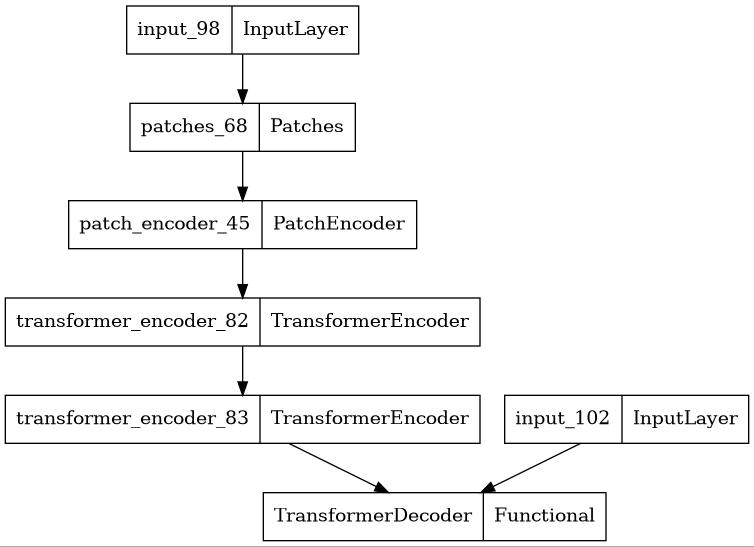

In [125]:
keras.utils.plot_model(build_model()[-1], 'TROCR.jpeg')